In [1]:
import os
import sys
sys.path.append('..')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from medpy.io import load as load_lbl
import random 

from dicomhd import io as dhd_io

from tfvpc.preprocessing.two_dim import extract_2d_patch
from tfvpc.preprocessing.two_dim import show_tf_batch
from tfvpc.preprocessing.two_dim import extract_2d_patch_labels
from tfvpc.preprocessing.two_dim import extract_annotated_2d_patch
from tfvpc.preprocessing.two_dim import recover_image
from tfvpc.model.resnet2D import Resnet2DBuilder
from tfvpc.preprocessing.two_dim import _int64_feature
from tfvpc.preprocessing.two_dim import _bytes_feature

%matplotlib inline

In [2]:
n_rows = 33
n_cols = 33
strides = 1
n_classes = 6
vocab = [1,2,3,4,5,6]
n_channel = 1
epoch = 100
batch_size = 128
seed = 2020
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# load image and extract patches
path_img = '../../data/dev/val/input/complete/'
path_lbl = '../../data/dev/val/output/complete/'
# img_fname = 'groundglass-f94824-Samir_reviewed_1-133'
# lbl_fname = 'groundglass-f94824-Samir_reviewed_1-219'
img_fname = 'consolidation-000063-Samir_reviewed_1-1024'
lbl_fname = 'consolidation-000063-Samir_reviewed_1-1104'

out_test_fname = 'test_rec'
out_path = '../data/tfrecods/'
out_ffname = os.path.join(out_path, out_test_fname + '.tfrecords')

array([46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 61, 62, 63, 64])

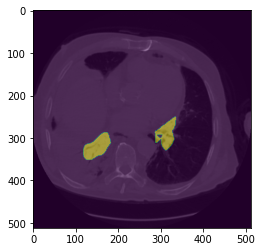

In [26]:
lbl_file_path = os.path.join(path_lbl, lbl_fname)
lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
lbl, label_header = load_lbl(lbl_file_path)
lbl = np.swapaxes(lbl,0,2)
# if lbl.sum() > 0:
# get indices for voxels with ann
idx_with_ann = np.ma.where(lbl.sum(axis=(1,2)) > 0)[0]
img_file_path = os.path.join(path_img, img_fname)
img = dhd_io.read_series(img_file_path)
# show GT
slice_nm = idx_with_ann[7]
plt.imshow(img.pixel_data[slice_nm], cmap='gray')
plt.imshow(lbl[slice_nm], alpha=0.5)

idx_with_ann

(116, 512, 512) (116, 512, 512)


array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145])

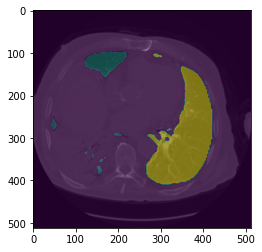

In [27]:
#lung segmentation
out_path = os.path.join(path_lbl, lbl_fname)
# seg_fname = 'lung_mask.nii.gz'
seg_fname = 'segmentation_0.nii.gz'
seg_file_path = os.path.join(out_path, seg_fname)
# img = nib.load(seg_file_path)
seg, seg_header = load_lbl(seg_file_path)
seg = np.swapaxes(seg,0,2)
seg[seg==3]=0
# plt.imshow(img.pixel_data[slice_nm,...], cmap='gray')
# plt.imshow(seg[slice_nm,...], alpha=0.5)
idx_with_ann = np.ma.where(seg.sum(axis=(1,2)) > 1024)[0]
img_ann = img.pixel_data[idx_with_ann]
seg_ann = seg[idx_with_ann]
plt.imshow(img_ann[23,...], cmap='gray')
plt.imshow(seg_ann[23,...], alpha=0.5)

print(img_ann.shape, seg_ann.shape) 
idx_with_ann

In [6]:
# load tf data
def _parse_image_test(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    image_feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'idx': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _decode_image_test(example):
    example['img'] = tf.io.parse_tensor(example['img'], out_type=tf.int16)
    example['idx'] = tf.io.parse_tensor(example['idx'], out_type=tf.int64)
    return example['img'], example['idx']


def load_test_dataset(fname):
    print(fname)
    dataset = tf.data.TFRecordDataset(fname)
    dataset = dataset.map(_parse_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(_decode_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

def get_lung_mask_limits(img, expand_limit=None):
    mask = img > 0
    indices = tf.where(mask)
    img_size = img.shape
    z_min, x_min, y_min = tf.reduce_min(indices, axis=0).numpy().tolist()
    z_max, x_max, y_max = tf.reduce_max(indices, axis=0).numpy().tolist()
    if expand_limit:
        z_min = max(z_min - expand_limit[0], 0)
        x_min = max(x_min - expand_limit[1], 0)
        y_min = max(y_min - expand_limit[2], 0)
        z_max = np.min([z_max + expand_limit[0], img_size[0]])
        x_max = np.min([x_max + expand_limit[1], img_size[1]])
        y_max = np.min([y_max + expand_limit[2], img_size[2]])
    return z_min, x_min, y_min, z_max, x_max, y_max



In [7]:
# # crop image
# with tf.device('/cpu:0'):
#     z_min, x_min, y_min, z_max, x_max, y_max = get_lung_mask_limits(seg, expand_limit=(0, 0, 0))
#     # print(img.pixel_data.shape)
#     # seg.shape
#     img_cropped = img.pixel_data[z_min:z_max, x_min:x_max, y_min: y_max]
#     seg_cropped = seg[z_min:z_max, x_min:x_max, y_min: y_max]
#     img_cropped.shape
#     plt.imshow(img_cropped[slice_nm,...], cmap='gray')
#     plt.imshow(seg_cropped[slice_nm,...], alpha = 0.5)


In [8]:
# def extract_3D_patch(
#     data,
#     ksizes=[33, 33, 33], 
#     strides=[3, 3, 3],
#     padding='SAME',
#     dtype=tf.float32
# ):
#     shape = data.shape
#     # convert image data to tensor
#     data = np.expand_dims(data, [0, -1])
#     data = tf.convert_to_tensor(data, dtype=dtype)
#     # Extract voulm patches: n_planes, n_rows, n_cols
#     tpatches = tf.extract_volume_patches(
#         data,
#         ksizes=[1, *ksizes, 1],
#         strides=[1, *strides, 1],
#         padding=padding
#     )
# #     tpatches = tf.reshape(tpatches, (-1, *shape, 1))
   
#     return tpatches

In [9]:
# with tf.device('/cpu:0'):
#     data = seg_cropped
#     xx = extract_3D_patch(data)

In [10]:
# with tf.device('/cpu:0'):
#     idx_with_ann = np.ma.where(seg_cropped.sum(axis=(1,2)) > 1024)[0]
# #     seg_ann = lbl[idx_with_ann, ...] #for whole volume
#     seg_ann = seg_cropped[slice_nm, ...]
#     seg_ann = tf.expand_dims(seg_ann, axis=0)
#     tlbl_patches = extract_2d_patch(seg_ann, n_rows, n_cols, strides)
#     img_ann = img_cropped[slice_nm, ...]
#     img_ann = tf.expand_dims(img_ann, axis=0)
#     timg_patches = extract_2d_patch(img_ann, n_rows, n_cols, strides)
#     timg_patches_with_ann, tlbl_patches_with_ann, tpatch_lbls_with_ann = \
#                         extract_annotated_2d_patch(timg_patches,
#                                                    tlbl_patches,
#                                                    n_rows,
#                                                    n_cols,
#                                                    1)

In [11]:
def extract_2d_patch(images, sizes, strides=[1, 1], padding='SAME'): 
    images = np.expand_dims(images, [-1])
    timages = tf.convert_to_tensor(images, dtype='float32')
    tpatches = tf.image.extract_patches(timages,
                                        sizes=[1, *sizes, 1],
                                        strides=[1, *strides, 1],
                                        rates=[1, 1, 1, 1],
                                        padding=padding)
    patch = tf.reshape(tpatches, (-1, *sizes, 1))
    return patch

In [12]:
# imgs = img_cropped[slice_nm, ...]
# print(imgs.shape)
# sizes = 3
# arr = np.array([
#   [
#      list(range(1, 11)),
#      list(range(11, 21)),
#      list(range(21, 31)),
#      list(range(31, 41)),
#      list(range(41, 51)),
#      list(range(51, 61)),
#      list(range(61, 71)),
#      list(range(71, 81)),
#      list(range(81, 91)),
#      list(range(91, 101)),
#  ],
#     [
#      list(range(101, 111)),
#      list(range(111, 121)),
#      list(range(121, 131)),
#      list(range(131, 141)),
#      list(range(141, 151)),
#      list(range(151, 161)),
#      list(range(161, 171)),
#      list(range(171, 181)),
#      list(range(181, 191)),
#      list(range(191, 201)),
#  ],  
# ])
# arr

In [13]:
# tnr = tf.constant(arr)
# imgs = tnr
# sizes = [3, 3]
# strides = [1, 1]
# dim = len(imgs.shape)
# padding = 'VALID'
# if dim == 3:
#     imgs = np.expand_dims(imgs, [-1])
# elif dim == 2:
#     imgs = np.expand_dims(imgs, [0, -1])
# else:
#     raise ValueError('Inputs imgs can only be onf dim 2 or 3.')
    
# # timages = tf.convert_to_tensor(imgs, dtype='float32')
# tpatches = tf.image.extract_patches(imgs,
#                                     sizes=[1, *sizes, 1],
#                                     strides=[1, *strides, 1],
#                                     rates=[1, 1, 1, 1],
#                                     padding=padding)
# patches = tf.reshape(tpatches, (-1, *sizes, 1))
# indices = list(range(patches.shape[0]))


In [17]:
img.pixel_data.shape
# slice_nm

(176, 512, 512)

In [28]:
#load model
model_fname = '../checkpoints/resnet34-2D-6cls_checkpoint-04-33.h5'
resnet = Resnet2DBuilder.build_resnet_34((33, 33, n_channel), n_classes)
resnet.load_weights(model_fname)
# resnet.summary()
resnet.compile(optimizer='adam', loss= 'categorical_crossentropy',)
    

for i in range(23, img_ann.shape[0]):
    anns = seg_ann[[i]]
    imgs = img_ann[[i]]
    sizes = [33, 33]
    strides = [1, 1]
    dim = len(imgs.shape)
    padding = 'SAME'
    if dim == 3:
        imgs = np.expand_dims(imgs, [-1])
        anns = np.expand_dims(anns, [-1])
    elif dim == 2:
        imgs = np.expand_dims(imgs, [0, -1])
        anns = np.expand_dims(anns, [0, -1])
    else:
        raise ValueError('Inputs imgs can only be onf dim 2 or 3.')

    # timages = tf.convert_to_tensor(imgs, dtype='float32')
    patches_i = tf.image.extract_patches(imgs,
                                        sizes=[1, *sizes, 1],
                                        strides=[1, *strides, 1],
                                        rates=[1, 1, 1, 1],
                                        padding=padding)
    anns_i = tf.image.extract_patches(anns,
                                        sizes=[1, *sizes, 1],
                                        strides=[1, *strides, 1],
                                        rates=[1, 1, 1, 1],
                                        padding=padding)
    
    patches_i = tf.reshape(patches_i, (-1, *sizes, 1))
    anns_i = tf.reshape(anns_i, (-1, *sizes, 1))
    indices_i = tf.constant(list(range(patches_i.shape[0])), dtype=tf.int32)
                            
    ann_ratio = tf.math.count_nonzero(anns_i, axis=[1, 2, 3]) / (sizes[0] * sizes[1])
    center_pixel_ann = anns_i[:, sizes[0]//2+1, sizes[0]//2+1, 0]

    mask = center_pixel_ann > 0
#     mask = ann_ratio > 0.8
    
    patches_with_ann_i = patches_i[mask]
    indices_with_ann_i = indices_i[mask]
    
    min_value = -1200
    max_value = -150
    #     timg_patches_with_ann = tf.clip_by_value(timg_patches_with_ann, min_value, max_value)
    patches_with_ann_i = tf.math.subtract(patches_with_ann_i, min_value) / (max_value - min_value)
    patch_probs_with_ann_i = resnet.predict(patches_with_ann_i, 32, verbose=1, workers=10, use_multiprocessing=True)
    patch_lbls_with_ann_i = np.argmax(patch_probs_with_ann_i, axis=1)
    lbls_i = tf.zeros(shape=(patches_i.shape[0]))
    lbls_i = tf.tensor_scatter_nd_add(
        lbls_i, 
        indices=tf.expand_dims(indices_with_ann_i, -1), 
        updates=patch_lbls_with_ann_i
    )
    lbls_i = tf.reshape(lbls_i, anns.shape)
    

    break
    


873/873 [==============================] - 10s 9ms/step


<IPython.core.display.Javascript object>


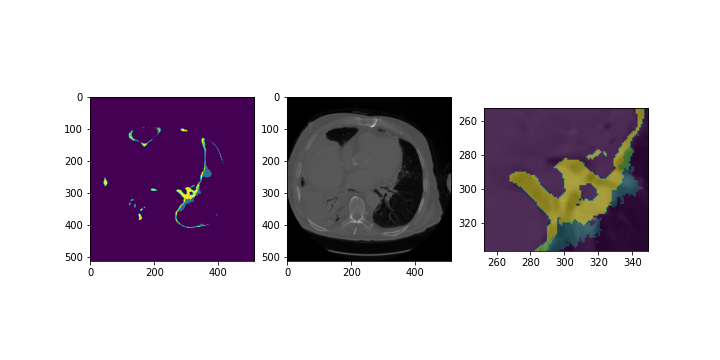

In [29]:
%matplotlib notebook
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(lbls_i[0, ..., 0])
axes[1].imshow(imgs[0, ..., 0], cmap='gray')
axes[2].imshow(imgs[0, ..., 0], cmap='gray')
axes[2].imshow(lbls_i[0, ..., 0], alpha=0.5)

In [ ]:
def show_tf_batch(image_batch, lbl_batch, vis):
    plt.figure(figsize=(20, 20))
    for n in range(image_batch.shape[0]):
        ax = plt.subplot(6, 10, n+1 )
        plt.imshow(image_batch[n], cmap='gray')
        if vis:
            plt.imshow(lbl_batch[n],alpha=0.4)
        plt.axis("off")
        
# show_tf_batch(timg_patches_with_ann, tlbl_patches_with_ann, 1)

In [ ]:
#load model
model_fname = '../checkpoints/resnet34-2D-6cls_checkpoint-04-33.h5'
resnet = Resnet2DBuilder.build_resnet_34((33, 33, n_channel), n_classes)
resnet.load_weights(model_fname)
resnet.summary()
resnet.compile(optimizer='adam', loss= 'categorical_crossentropy',)


In [ ]:
#normalize and clip values
with tf.device('/cpu:0'):
    
# timg_patches_with_ann.numpy()

In [ ]:
patches.shape

In [ ]:
# predict labels
# with tf.device('/cpu:0'):
predicted_lbls = resnet.predict(patches, 32, verbose=1)
# predicted_lbls = np.argmax(predicted_lbls, axis=1)
# predicted_lbl_patches = tf.ones_like(patches, dtype=tf.int64)
# predicted_lbls = tf.convert_to_tensor(predicted_lbls, dtype=tf.int64)
# predicted_lbl_patches = tf.reshape(predicted_lbls, [predicted_lbls.shape[0],1,1,1]) * predicted_lbl_patches
# print(predicted_lbl_patches.shape)

In [ ]:
#Assing label to center of the patches
predicted_lbls

In [ ]:
# recounstruct patches
with tf.device('/cpu:0'):
    predicted_lbl_patches = tf.cast(predicted_lbl_patches, dtype=tf.float32)
    recounstructed_img = recover_image(predicted_lbl_patches, 
                        image_size=(320, 359), 
                        n_images=(10,11))
    plt.imshow(recounstructed_img)
    recounstructed_img

In [ ]:
# exclude other class
cls_to_vis = 4
mask = recounstructed_img != cls_to_vis
cls_recounstructed_img = tf.where(mask, tf.zeros(tf.shape(recounstructed_img)), recounstructed_img ) 
plt.imshow(img_cropped[slice_nm], cmap='gray')
plt.imshow(cls_recounstructed_img, alpha=0.5)

In [ ]:
org_img = recounstructed_img.numpy()

In [ ]:
mask_img = seg_cropped[slice_nm, ...]

In [ ]:
print(org_img.shape, mask_img.shape)

In [ ]:
mask = mask_img == 0
# seg[seg==3]=0
org_img[mask] = 0

In [ ]:
plt.imshow(img_cropped[slice_nm], cmap='gray')
plt.imshow(org_img, alpha=0.5)